In [4]:
import pandas as pd
import numpy as np
import json

from plotting_tools import *
import geopandas as gpd

In [5]:
experiment_series = "pop8"

df = pd.read_csv(f"../../preprocessing/preprocessed_data/{experiment_series}/num_agents_infections_area_{experiment_series}.txt")

### Agents per area

In [6]:
with open("../../preprocessing/preprocessed_data/tandler_upstream_gebiete.json") as f:
    tandler_upstream_gebiete = json.load(f)

tandler_upstream_gebiete = {k: [int(x) for x in v] for k, v in tandler_upstream_gebiete.items()}

In [16]:
gebiete = gpd.read_file("MunichModel_shape/Gebiete.shp")
gebiete.set_crs(epsg=32632)
gebiete["area"] = gebiete.geometry.area / 1_000_000  # Convert to square kilometers

In [17]:
gebiete.geometry.area.sum()/1_000_000

np.float64(311.4320859813416)

In [21]:
df_sub = df.loc[(df.Sim==1)&(df.t==0)]

In [22]:
df_sub

,Sim,t,area,NumInfected,NewInfections,NumAgents
0,1,0,0,0,0,0
1,1,0,1,0,0,7270
2,1,0,2,0,0,0
3,1,0,3,0,0,8991
4,1,0,4,2,0,8244
...,...,...,...,...,...,...
239,1,0,239,0,0,2813
240,1,0,240,1,0,2822
241,1,0,241,2,0,5082
242,1,0,242,0,0,2682


In [29]:
gebiete = gebiete.merge(df_sub, left_on="Name", right_on="area", how="left", suffixes=("", "_y"), validate="one_to_one")[["Name", "geometry", "NumAgents", "area"]]

gebiete.head()

,Name,geometry,NumAgents,area
0,201,"POLYGON ((690550.062 5332480.949, 691069.156 5...",3561,0.343494
1,221,"POLYGON ((696263.806 5337159.535, 694264.699 5...",4797,1.947244
2,222,"POLYGON ((697263.369 5337171.641, 697276.083 5...",7508,2.019481
3,29,"POLYGON ((696289.237 5335158.663, 696276.523 5...",4434,0.994401
4,142,"POLYGON ((688874.057 5331599.98, 688353.138 53...",6392,0.288198


In [33]:
gebiete.loc[gebiete.Name==182]

,Name,geometry,NumAgents,area
86,182,"POLYGON ((689318.595 5333021.618, 689317.942 5...",4337,0.001244


In [32]:
gebiete.NumAgents.describe()

count      235.000000
mean      6540.361702
std       4207.697654
min        694.000000
25%       4153.000000
50%       5444.000000
75%       7698.500000
max      25483.000000
Name: NumAgents, dtype: float64

In [38]:
(gebiete.NumAgents/gebiete.area).describe()

count    235.000000
mean       0.022421
std        0.227136
min        0.000232
25%        0.003238
50%        0.005587
75%        0.009712
max        3.487114
dtype: float64

In [48]:
gebiete.sort_values("pop_density", ascending=False).head(10)[["Name", "NumAgents", "area", "pop_density"]]

,Name,NumAgents,area,pop_density
86,182,4337,0.001244,3.487114
114,146,4241,0.042829,0.099021
53,161,6097,0.136561,0.044647
143,162,6106,0.163710,0.037298
207,114,25483,1.000094,0.025481
85,85,22925,1.000103,0.022923
4,142,6392,0.288198,0.022179
227,15,21612,1.000105,0.021610
75,84,20912,1.000092,0.020910
26,110,20704,1.000076,0.020702


In [45]:
gebiete.loc[gebiete.pop_density>0.05]

,Name,geometry,NumAgents,area,pop_density
86,182,"POLYGON ((689318.595 5333021.618, 689317.942 5...",4337,0.001244,3.487114
114,146,"POLYGON ((690409.007 5328207.925, 690305.376 5...",4241,0.042829,0.099021


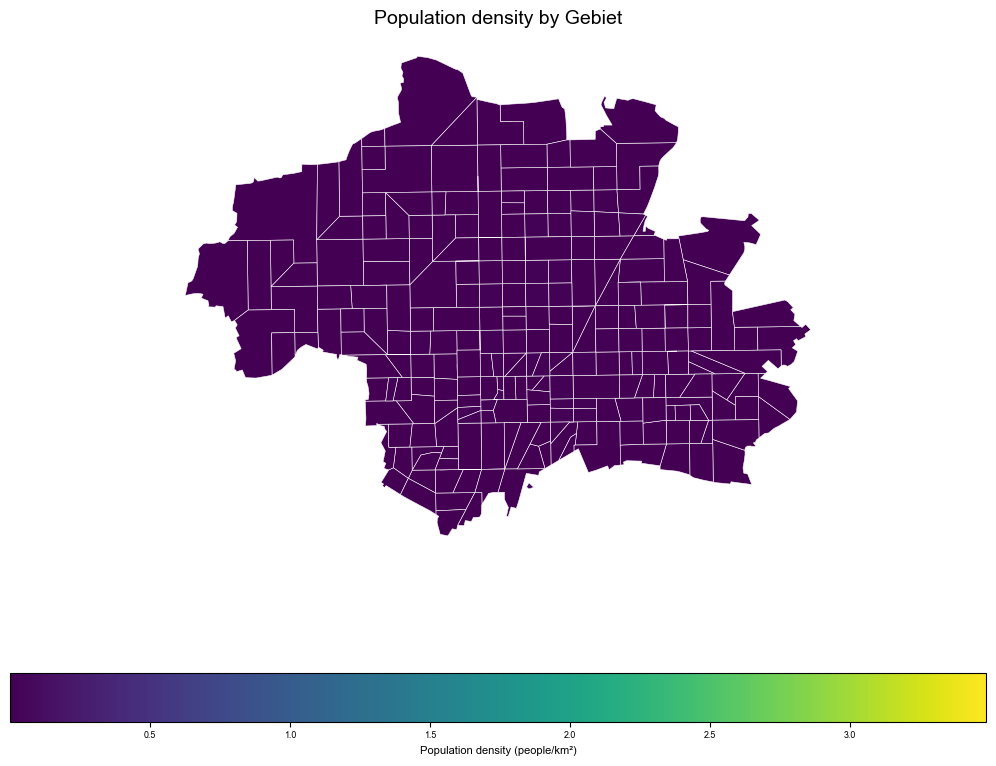

In [42]:
gebiete['pop_density'] = (gebiete.NumAgents)/(gebiete.area)  # people per km²

# ── 2.  plot with a nice colour scale & quantile legend ───────────────
fig, ax = plt.subplots(figsize=(10, 8))
gebiete.plot(
    column='pop_density',
    cmap='viridis',
    #scheme='quantiles',   # equal-count class breaks
    k=5,                  # number of classes (adjust as you like)
    linewidth=0.4,
    edgecolor='white',
    legend=True,
    legend_kwds={'label': "Population density (people/km²)",
                 'orientation': "horizontal"},
    ax=ax
)

# ── 3.  aesthetics ────────────────────────────────────────────────────
ax.set_title("Population density by Gebiet", fontsize=14)
ax.set_axis_off()         # hide axes ticks/labels for a clean map
plt.tight_layout()
plt.show()

### Maximum agents

<Axes: title={'center': 'Number of agents in area 0 (Sim 93)'}, xlabel='Time', ylabel='Number of agents'>

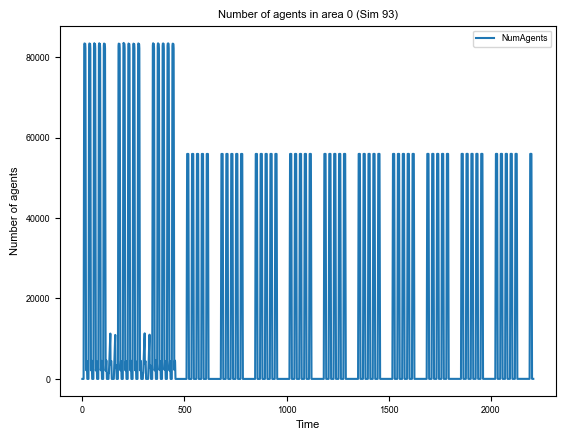

In [72]:
df.loc[(df.Sim==93)&(df.area==0)].plot(x="t", y="NumAgents", title="Number of agents in area 0 (Sim 93)", xlabel="Time", ylabel="Number of agents")

In [73]:
df.loc[df["NumAgents"]==83521]

,Sim,t,area,NumInfected,NewInfections,NumAgents
49636920,93,202,0,88,2,83521


In [74]:
df_max = df.groupby("area")["NumAgents"].max().reset_index()

In [76]:
df_max.loc[df_max.area.isin(areas_not_in_gebiete_list)]

,area,NumAgents
0,0,83521
2,2,0
6,6,0
8,8,0
146,146,4325
166,166,0
168,168,0
182,182,4995
205,205,0
218,218,0


### Start agents (i.e. citizens)

In [18]:
df.groupby(["t", "Sim"])["NumAgents"].sum()

t     Sim
0     1      1536985
      2      1536985
      3      1536985
      4      1536985
      5      1536985
              ...   
2208  96     1536985
      97     1536985
      98     1536985
      99     1536985
      100    1536985
Name: NumAgents, Length: 220900, dtype: int64

In [42]:
df = df.loc[(df.t==0)&(df.Sim==1)]

n_agents = {}
for key in tandler_upstream_gebiete.keys():
    df_sub = df.loc[(df.area.isin(tandler_upstream_gebiete[key]))]
    n_agents[key] = df_sub["NumAgents"].sum()

In [ ]:
all_areas_in_gebiete = set()
for areas in tandler_upstream_gebiete.values():
    all_areas_in_gebiete.update(areas)

areas_not_in_gebiete = set(df["area"].unique()) - all_areas_in_gebiete
areas_not_in_gebiete_list = [int(a) for a in areas_not_in_gebiete]

{np.int64(0),
 np.int64(2),
 np.int64(6),
 np.int64(8),
 np.int64(146),
 np.int64(166),
 np.int64(168),
 np.int64(182),
 np.int64(205),
 np.int64(218),
 np.int64(232)}

In [48]:
areas_not_in_gebiete_list

[0, 2, 6, 166, 8, 168, 232, 205, 146, 182, 218]

In [51]:
df.loc[df.area.isin(areas_not_in_gebiete_list),:]

,Sim,t,area,NumInfected,NewInfections,NumAgents
0,1,0,0,0,0,0
2,1,0,2,0,0,0
6,1,0,6,0,0,0
8,1,0,8,0,0,0
146,1,0,146,1,1,4241
166,1,0,166,0,0,0
168,1,0,168,0,0,0
182,1,0,182,1,0,4337
205,1,0,205,0,0,0
218,1,0,218,0,0,0


In [53]:
df.loc[df.area.isin(areas_not_in_gebiete_list),:].NumAgents.sum()

np.int64(8578)

In [32]:
n_upstream_agents = pd.DataFrame(list(n_agents.items()), columns=["Key", "NumAgents"])

In [36]:
n_upstream_agents

,Key,NumAgents
0,N_Ub,7123
1,S_M4,936099
2,C_U,8578
3,S_Ua,21865
4,N_Uc,12331
5,E_U,40185
6,SCE_D2,1327986
7,S_M3,637134
8,S_Ub,28344
9,N_D,200421


In [57]:
8578/(1528407+8578)*100

0.5581056418898038

In [12]:
df.loc[(df.t==0)&(df.Sim==1)]

,Sim,t,area,NumInfected,NewInfections,NumAgents
0,1,0,0,0,0,0
1,1,0,1,0,0,7270
2,1,0,2,0,0,0
3,1,0,3,0,0,8991
4,1,0,4,2,0,8244
...,...,...,...,...,...,...
239,1,0,239,0,0,2813
240,1,0,240,1,0,2822
241,1,0,241,2,0,5082
242,1,0,242,0,0,2682


In [1]:
import h5py
import numpy as np
from collections import defaultdict
import pandas as pd 

from plotting_tools import *
import geopandas as gpd

In [2]:
file_path = "../../data/memilio_input/"

In [3]:
df_ABM_loc_size = pd.read_csv(file_path + "../0_size_per_loc.txt", sep=" ", header=None, dtype={0: str})
df_ABM_loc_size.columns = ["loc", "n_Agents"]

def location_type(loc):
    """
    Function to determine the type of location based on its name.
    """
    if loc.startswith("00"):
        return "home"
    elif loc.startswith("01"):
        return "school"
    elif loc.startswith("02"):
        return "work"
    elif loc.startswith("03"):
        return "social event"
    elif loc.startswith("04"):
        return "Shop"
    elif loc.startswith("05"):
        return "Hospital"
    elif loc.startswith("06"):
        return "ICU"
    elif loc.startswith("10"):
        return "Cemetery"
    else:
        return "Unknown"
    
df_ABM_loc_size["loc_type"] = df_ABM_loc_size["loc"].apply(location_type)

In [4]:
df_ABM_loc_size.head()

,loc,n_Agents,loc_type
0,00100000,1,home
1,001000000,5,home
2,001000001,2,home
3,001000002,1,home
4,001000003,1,home


In [24]:
df_ABM_tan_loc_mapping = pd.read_csv(file_path + "../1_mapping_tan_locs.txt", sep=" ", header=None, index_col=None, dtype={0: str}).iloc[:,:2]
df_ABM_tan_loc_mapping.columns = ["loc", "tan_loc"]

In [26]:
df_loc = pd.merge(df_ABM_loc_size, df_ABM_tan_loc_mapping, on="loc", how="outer")

In [31]:
df_loc.loc[df_loc.tan_loc==64].groupby("loc_type").agg({"n_Agents": "sum"}).reset_index().sort_values("n_Agents", ascending=False)

,loc_type,n_Agents
3,social event,7784.0
1,home,7174.0
0,Shop,5370.0
4,work,3306.0
2,school,316.0


In [30]:
df_loc.loc[df_loc.tan_loc==234].groupby("loc_type").agg({"n_Agents": "sum"}).reset_index().sort_values("n_Agents", ascending=False)

,loc_type,n_Agents
1,home,7136.0
0,Shop,5143.0
3,social event,4898.0
4,work,2544.0
2,school,631.0


In [35]:
255577.0+197302.0

452879.0

In [39]:
1005+315

1320

In [38]:
(1955-1005)/3

316.6666666666667

In [34]:
df_loc.groupby("loc_type").agg({"n_Agents": "max"}).reset_index().sort_values("n_Agents", ascending=False)

,loc_type,n_Agents
1,ICU,255577.0
0,Hospital,197302.0
5,social event,3829.0
2,Shop,1605.0
6,work,970.0
4,school,768.0
3,home,7.0


In [33]:
df_loc.loc[df_loc.tan_loc==64].groupby("loc_type").agg({"n_Agents": "max"}).reset_index().sort_values("n_Agents", ascending=False)

,loc_type,n_Agents
3,social event,2001.0
0,Shop,867.0
4,work,792.0
2,school,316.0
1,home,7.0


In [32]:
df_loc.loc[df_loc.tan_loc==234].groupby("loc_type").agg({"n_Agents": "max"}).reset_index().sort_values("n_Agents", ascending=False)

,loc_type,n_Agents
0,Shop,1605.0
3,social event,634.0
2,school,631.0
4,work,146.0
1,home,7.0


In [ ]:
df_loc.loc[df_loc.tan_loc==].groupby("loc_type").agg({"n_Agents": "sum"}).reset_index().sort_values("n_Agents", ascending=False)

In [ ]:
8743027

In [24]:
1536985*4 < df_ABM_loc_size.n_Agents.sum()

np.True_

In [19]:
df =pd.read_csv(file_path+"persons.csv")
shape_file = gpd.read_file(file_path+"Munich_shape250319/Verschnitt_DLR_TAN_Rep.shp")


In [20]:
df.head()

,Unnamed: 0,puid,age,home_zone,home_id,shop_zone,shop_id,event_zone,event_id,work_zone,work_id,school_zone,school_id
0,0,863051,50,91620671,86305,91620671,14601362,91620671,14601315,91820112,14829646,-2,-2
1,1,863791,50,91620691,86379,91620691,14629079,91620691,14625743,91820112,14829638,-2,-2
2,2,883451,50,91620811,88345,91820012,14582286,91620811,14598482,91820112,14829614,-2,-2
3,3,1247641,51,91620521,124764,91620521,14393929,91620521,14397895,91620521,14395347,-2,-2
4,4,1257601,57,91620591,125760,91620591,14425142,91820025,14828673,91870042,15454696,-2,-2


In [21]:
df.shape

(1536985, 13)

In [29]:
memilio_zone = shape_file.loc[shape_file["ID_TAN"]==64, "id_n"].iloc[0]

In [36]:
shape_file.loc[shape_file["id_n"]==memilio_zone]

,id,geom,id_n,ags,gen,ind,ID_TAN,geometry
53,4613,0106000020E6100000010000000103000000010000001B...,91620111,9162000,München,4612,64,"POLYGON ((691190.778 5343013.348, 691189.657 5..."
104,4613,0106000020E6100000010000000103000000010000001B...,91620111,9162000,München,4612,234,"POLYGON ((690524.966 5343093.232, 690190.114 5..."


<Axes: >

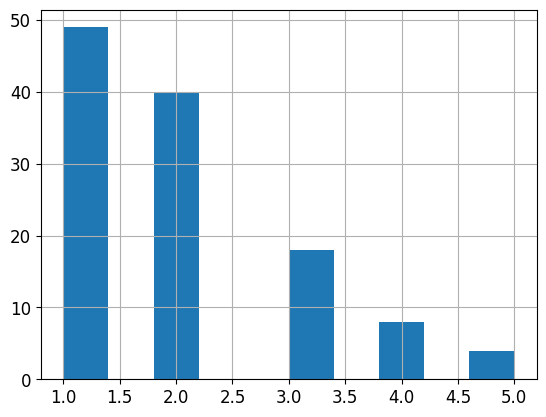

In [41]:
shape_file.groupby("id_n")["ID_TAN"].count().hist()

In [33]:
citizens = df.loc[df["home_zone"]==memilio_zone, :].shape[0]

citizens_and_working_in_zone = df.loc[(df["home_zone"]==memilio_zone)&(df["work_zone"]==memilio_zone), :].shape[0]
citizens_and_working_outside_zone = df.loc[(df["home_zone"]==memilio_zone)&(df["work_zone"]!=memilio_zone), :].shape[0]

print(f"Citizens in zone {memilio_zone}: {citizens}")
print(f"Citizens working in zone {memilio_zone}: {citizens_and_working_in_zone}")
print(f"Citizens working outside zone {memilio_zone}: {citizens_and_working_outside_zone}")

Citizens in zone 91620111: 14349
Citizens working in zone 91620111: 3465
Citizens working outside zone 91620111: 10884


### Questions

kommen in 64 neue agenten rein / wie viele? 
wie viele locations sind da? 

3 Tage rauspicken und zu welchen Tageszeiten geht das hoch und runter? 